In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import pandas as pd
from pathlib import Path
# from pyts.image import GramianAngularField # not currently working in env 
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import torch
from tqdm.notebook import tqdm
import fastai
from fastai.vision.all import *

# # load any resources fr4om this library 
from src import data

In [21]:
days = list(range(290, 305))
days

[290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304]

In [22]:
year = 2012
location = "hawaii"

In [23]:
dataframes = list()
for d in days: 
    
    print("\n--- " + str(d) + "---")
    
    # read in the data 
    df = data.read_day(
        location=location,
        year=year,
        day_of_year=d
    )
    dataframes.append(df)


  0%|          | 8/1656 [00:00<00:21, 76.12it/s]


--- 290---
Reading dataframes...


100%|██████████| 1656/1656 [00:22<00:00, 72.51it/s]


Concatenating dataframes...


  1%|          | 9/1654 [00:00<00:19, 86.30it/s]


--- 291---
Reading dataframes...


100%|██████████| 1654/1654 [00:22<00:00, 74.59it/s]


Concatenating dataframes...


  0%|          | 8/1646 [00:00<00:22, 73.45it/s]


--- 292---
Reading dataframes...


100%|██████████| 1646/1646 [00:21<00:00, 76.04it/s]


Concatenating dataframes...


  0%|          | 8/1649 [00:00<00:22, 72.40it/s]


--- 293---
Reading dataframes...


100%|██████████| 1649/1649 [00:21<00:00, 76.09it/s]


Concatenating dataframes...


  0%|          | 6/1655 [00:00<00:27, 59.20it/s]


--- 294---
Reading dataframes...


100%|██████████| 1655/1655 [00:21<00:00, 75.86it/s]


Concatenating dataframes...


  0%|          | 6/1648 [00:00<00:28, 57.90it/s]


--- 295---
Reading dataframes...


100%|██████████| 1648/1648 [00:22<00:00, 73.94it/s]


Concatenating dataframes...


  0%|          | 8/1655 [00:00<00:21, 76.54it/s]


--- 296---
Reading dataframes...


100%|██████████| 1655/1655 [00:22<00:00, 74.62it/s]


Concatenating dataframes...


  0%|          | 7/1647 [00:00<00:32, 50.49it/s]


--- 297---
Reading dataframes...


100%|██████████| 1647/1647 [00:21<00:00, 76.36it/s]


Concatenating dataframes...


  0%|          | 7/1657 [00:00<00:24, 68.48it/s]


--- 298---
Reading dataframes...


100%|██████████| 1657/1657 [00:21<00:00, 75.57it/s]


Concatenating dataframes...


  0%|          | 7/1656 [00:00<00:24, 68.39it/s]


--- 299---
Reading dataframes...


100%|██████████| 1656/1656 [00:21<00:00, 76.01it/s]


Concatenating dataframes...


  1%|          | 8/1595 [00:00<00:19, 79.57it/s]


--- 300---
Reading dataframes...


100%|██████████| 1595/1595 [00:22<00:00, 72.34it/s]


Concatenating dataframes...


  1%|          | 8/1596 [00:00<00:19, 79.83it/s]


--- 301---
Reading dataframes...


100%|██████████| 1596/1596 [00:22<00:00, 72.21it/s]


Concatenating dataframes...


  1%|          | 10/1597 [00:00<00:17, 89.52it/s]


--- 302---
Reading dataframes...


100%|██████████| 1597/1597 [00:22<00:00, 71.94it/s]


Concatenating dataframes...


  0%|          | 7/1597 [00:00<00:24, 65.30it/s]


--- 303---
Reading dataframes...


100%|██████████| 1597/1597 [00:22<00:00, 71.91it/s]


Concatenating dataframes...


  1%|          | 8/1596 [00:00<00:21, 72.74it/s]


--- 304---
Reading dataframes...


100%|██████████| 1596/1596 [00:22<00:00, 70.67it/s]


Concatenating dataframes...


In [24]:
# concatenate the dataframes loaded previously into one large dataframe 
df_all = pd.concat(dataframes) 

In [47]:
# now let's step through and create the data for each of the ground station, satellite pairs 
combinations = list(set(["_".join(x.split("_")[0:3]) for x in df_all.columns.values]))
combinations[0:5]

['puka__G05', 'alep__G24', 'jcuz__G05', 'byrl__G06', 'yeep__G26']

In [48]:
len(combinations)

1662

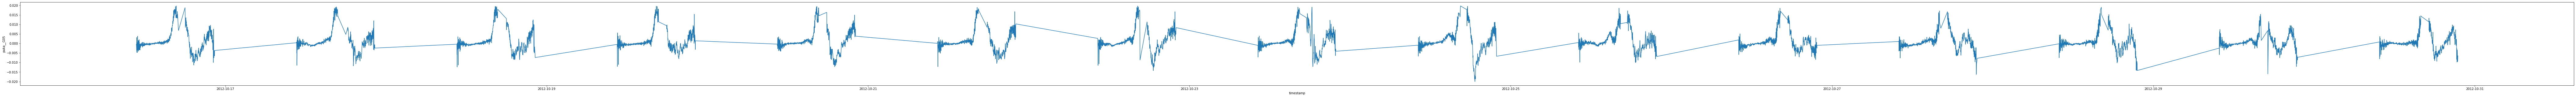

KeyboardInterrupt: 

In [50]:
for i in tqdm(combinations):
    
    # let's filter this down to just one satellite for now 
    df_model = df_all.filter(regex=i, axis=1).resample("1min").mean()
    
    plt.figure(figsize=(150, 5))
    ax = sns.lineplot(
        data=df_model, x=df_model.index, y=i
    )
    plt.show()
    
    events = np.split(df_model, np.where(np.isnan(df_model))[0])
    
    events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
    
    events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]
    
    normalized_events = list()
    for ev in events: 

        # for each column in the data, rescale -1 to 1 
        col_data = list()
        for col in ev.columns.values:

            normalized_data = minmax_scale(
                        ev[col].dropna(), 
                        feature_range=(-1, 1)
                    )
            col_data.append(normalized_data)

        df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
        df_period["timestamp"] = ev[col].index
        df_period.index = df_period["timestamp"]
        df_period = df_period.drop(columns=["timestamp"])

        # convert to seconds of the day for later annotation 
        df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

        normalized_events.append(df_period)
        
    # we want to "window" across the remaining data and generate square images 
    WINDOW_SIZE = 60
    
    for period, doy in zip(events, days): 
    
        # create a directory for this new data 
    #     if not os.path.exists("../data/image_based/hawaii/ahup__G07/" + str(doy)):
        Path("../data/image_based/hawaii/" + i + "/" + str(doy) + "/GAF").mkdir(parents=True, exist_ok=True)
        Path("../data/image_based/hawaii/" + i + "/" + str(doy) + "/lineplot").mkdir(parents=True, exist_ok=True)

        for idx in list(range(period.shape[0])):

            # get subsetted window 
            subset = period.iloc[idx:idx+WINDOW_SIZE, :]
            if subset.shape[0] < WINDOW_SIZE:
                pass

            else:

                # generate the base image 
                figure = plt.figure(figsize=(5,5), frameon=False)

                ax = plt.Axes(figure, [0., 0., 1., 1.])
                ax.set_axis_off()
                figure.add_axes(ax)

                figure = plt.plot(list(range(idx, idx+WINDOW_SIZE)), subset["ahup__G07"])[0]

                x_axis = figure.axes.get_xaxis()
                x_axis.set_visible(False)

                y_axis = figure.axes.get_yaxis()
                y_axis.set_visible(False)
    #             plt.show() 

                plt.savefig("../data/image_based/hawaii/" + i + "/" + str(doy) + "/lineplot/" + str(doy) + "_" + str(idx) + "_" + str(idx + WINDOW_SIZE) + ".jpg")

                plt.close()

                # now generate the field 
                transformer = GramianAngularField()
                X_new = transformer.fit_transform(np.array([subset[i]]))

                figure = plt.figure(figsize=(5,5), frameon=False)

                ax = plt.Axes(figure, [0., 0., 1., 1.])
                ax.set_axis_off()
                figure.add_axes(ax)

                figure = plt.imshow(X_new[0], cmap='viridis', origin='lower')

                x_axis = figure.axes.get_xaxis()
                x_axis.set_visible(False)

                y_axis = figure.axes.get_yaxis()
                y_axis.set_visible(False)

    #             plt.show()

                plt.savefig("../data/image_based/hawaii/" + i + "/" + str(doy) + "/GAF/" + str(doy) + "_" + str(idx) + "_" + str(idx + WINDOW_SIZE) + "_GAF.jpg")


                plt.close()

            
                


In [25]:
# let's filter this down to just one satellite for now 
df_model = df_all.filter(regex='ahup__G07', axis=1).resample("1min").mean()

In [26]:
df_model.shape

(21600, 6)

In [27]:
df_model.head()

ahup__G07  ahup__G07_lat  ahup__G07_lon  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-16 00:00:00        NaN            NaN            NaN              NaN   
2012-10-16 00:01:00        NaN            NaN            NaN              NaN   
2012-10-16 00:02:00        NaN            NaN            NaN              NaN   
2012-10-16 00:03:00        NaN            NaN            NaN              NaN   
2012-10-16 00:04:00        NaN            NaN            NaN              NaN   

                     ahup__G07_ele  ahup__G07_azi  
timestamp                                          
2012-10-16 00:00:00            NaN            NaN  
2012-10-16 00:01:00            NaN            NaN  
2012-10-16 00:02:00            NaN            NaN  
2012-10-16 00:03:00            NaN            NaN  
2012-10-16 00:04:00            NaN            NaN

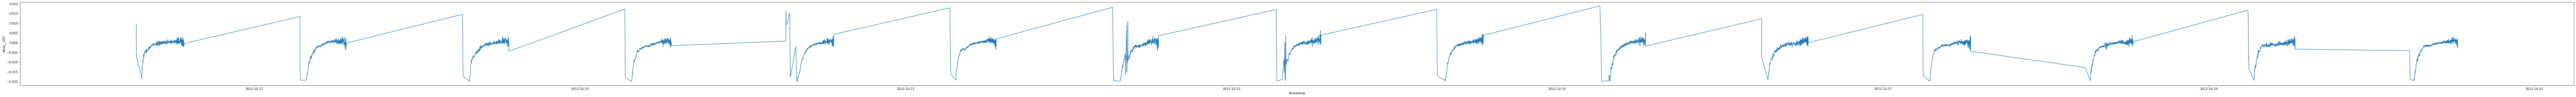

In [28]:
plt.figure(figsize=(150, 5))
ax = sns.lineplot(
    data=df_model, x=df_model.index, y="ahup__G07"
)
plt.show()

In [29]:
events = np.split(df_model, np.where(np.isnan(df_model))[0])

In [30]:
len(events)

97111

In [31]:
events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]

In [32]:
len(events)

97111

In [33]:
events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

In [34]:
len(events)

15

In [35]:
normalized_events = list()
for ev in events: 

    # for each column in the data, rescale -1 to 1 
    col_data = list()
    for col in ev.columns.values:

        normalized_data = minmax_scale(
                    ev[col].dropna(), 
                    feature_range=(-1, 1)
                )
        col_data.append(normalized_data)

    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
    df_period["timestamp"] = ev[col].index
    df_period.index = df_period["timestamp"]
    df_period = df_period.drop(columns=["timestamp"])

    # convert to seconds of the day for later annotation 
    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

    normalized_events.append(df_period)

In [36]:
len(normalized_events)

15

In [37]:
# we want to "window" across the remaining data and generate square images 
WINDOW_SIZE = 60

In [ ]:
# for each period (event)
# for each observation 
# get the data + window if defined 
# generate the normal plot 
# generate the GADF 
# plot them side by side 
# save the image to disk then download locally and go through and label them 

In [ ]:
for period, doy in tqdm(zip(events, days), total=len(events)): 
    
    # create a directory for this new data 
#     if not os.path.exists("../data/image_based/hawaii/ahup__G07/" + str(doy)):
    Path("../data/image_based/hawaii/ahup__G07/" + str(doy) + "/GAF").mkdir(parents=True, exist_ok=True)
    Path("../data/image_based/hawaii/ahup__G07/" + str(doy) + "/lineplot").mkdir(parents=True, exist_ok=True)
    
    for idx in list(range(period.shape[0])):
        
        # get subsetted window 
        subset = period.iloc[idx:idx+WINDOW_SIZE, :]
        if subset.shape[0] < WINDOW_SIZE:
            pass
        
        else:
            
            # generate the base image 
            figure = plt.figure(figsize=(5,5), frameon=False)
            
            ax = plt.Axes(figure, [0., 0., 1., 1.])
            ax.set_axis_off()
            figure.add_axes(ax)
            
            figure = plt.plot(list(range(idx, idx+WINDOW_SIZE)), subset["ahup__G07"])[0]
            
            x_axis = figure.axes.get_xaxis()
            x_axis.set_visible(False)

            y_axis = figure.axes.get_yaxis()
            y_axis.set_visible(False)
#             plt.show() 
            
            plt.savefig("../data/image_based/hawaii/ahup__G07/" + str(doy) + "/lineplot/" + str(doy) + "_" + str(idx) + "_" + str(idx + WINDOW_SIZE) + ".jpg")
            
            plt.close()
            
            # now generate the field 
            transformer = GramianAngularField()
            X_new = transformer.fit_transform(np.array([subset["ahup__G07"]]))
            
            figure = plt.figure(figsize=(5,5), frameon=False)
        
            ax = plt.Axes(figure, [0., 0., 1., 1.])
            ax.set_axis_off()
            figure.add_axes(ax)
            
            figure = plt.imshow(X_new[0], cmap='viridis', origin='lower')
            
            x_axis = figure.axes.get_xaxis()
            x_axis.set_visible(False)

            y_axis = figure.axes.get_yaxis()
            y_axis.set_visible(False)
            
#             plt.show()
            
            plt.savefig("../data/image_based/hawaii/ahup__G07/" + str(doy) + "/GAF/" + str(doy) + "_" + str(idx) + "_" + str(idx + WINDOW_SIZE) + "_GAF.jpg")

            
            plt.close()

            
                

## Modeling

In [17]:
data = get_image_files("/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled")

In [18]:
data

(#4343) [Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_135_195_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_126_186_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_142_202_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_151_211_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_78_138_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_105_165_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled/anomalous/302_116_176_GAF.jpg'),Path('/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image

In [172]:
dls = ImageDataLoaders.from_folder(
    "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/ahup__G07/labeled", 
    item_tfms=Resize(224),
    valid_pct=0.5,
    bs=32,
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

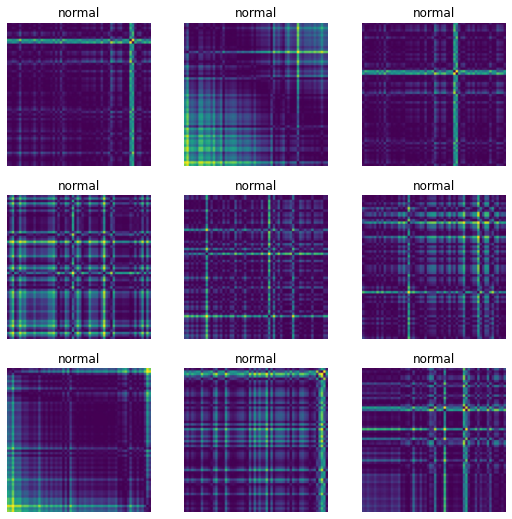

In [173]:
dls.show_batch()

In [192]:
dls.dataset

(#2172) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...]

In [193]:



# # TODO: remove manual coding below 
# n_0, n_1 = 4259, 84

# print(dict(Counter(dls.targets)))

# w_0 = (n_0 + n_1) / (2.0 * n_0)
# w_1 = (n_0 + n_1) / (2.0 * n_1)

# # Important: Convert Weights To Float Tensor
# class_weights = torch.FloatTensor([0.25, 1.]).cuda()

# print(class_weights)

# loss_func = CrossEntropyLossFlat(weight=class_weights)

learn = cnn_learner(
    dls, 
    resnet18, 
    metrics=error_rate, 
#     loss_func=loss_func, 
    pretrained=False, 
    normalize=True
)
# learn = create_cnn(dls, resnet34, metrics=error_rate, callback_fns=ShowGraph)

learn.show_training_loop()


Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

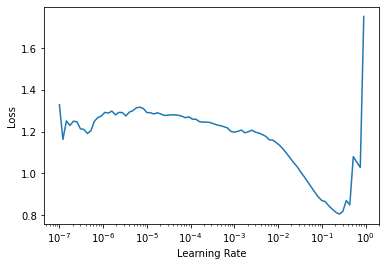

In [194]:
lr_min, lr_steep = learn.lr_find()

In [195]:
lr_min * 0.01

0.00025118863582611085

In [196]:
# cosine annealing 
sched = {'lr': SchedCos(0, 2)}

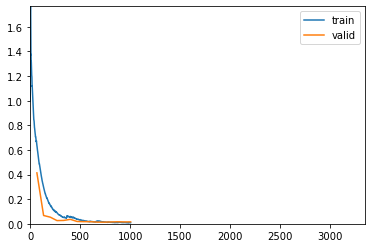

Better model found at epoch 0 with valid_loss value: 0.4137084484100342.
Better model found at epoch 1 with valid_loss value: 0.06749753654003143.
Better model found at epoch 2 with valid_loss value: 0.05386008694767952.
Better model found at epoch 3 with valid_loss value: 0.026075266301631927.
Epoch 5: reducing lr to 0.0001
Better model found at epoch 6 with valid_loss value: 0.018925296142697334.
Better model found at epoch 7 with valid_loss value: 0.01761021465063095.
Better model found at epoch 8 with valid_loss value: 0.01716008596122265.
Better model found at epoch 9 with valid_loss value: 0.013723707757890224.
Better model found at epoch 10 with valid_loss value: 0.01340523362159729.
Epoch 11: reducing lr to 1e-05
Epoch 13: reducing lr to 1.0000000000000002e-06
No improvement since epoch 9: early stopping


In [197]:
learn.fit(
    50, 
    lr=0.0005,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=2
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=5,
            min_delta=0.0005
        ),
        SaveModelCallback()
    ]
) 

In [198]:
# learn.recorder.plot_sched()

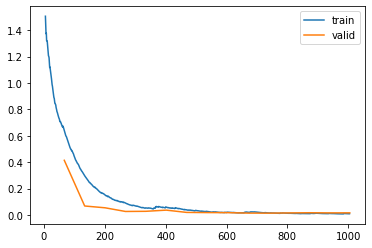

In [199]:
learn.recorder.plot_loss()

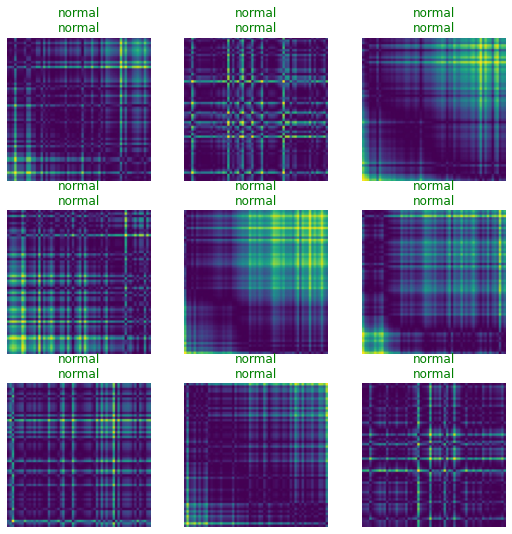

In [200]:
learn.show_results()

In [201]:
interp = ClassificationInterpretation.from_learner(learn)

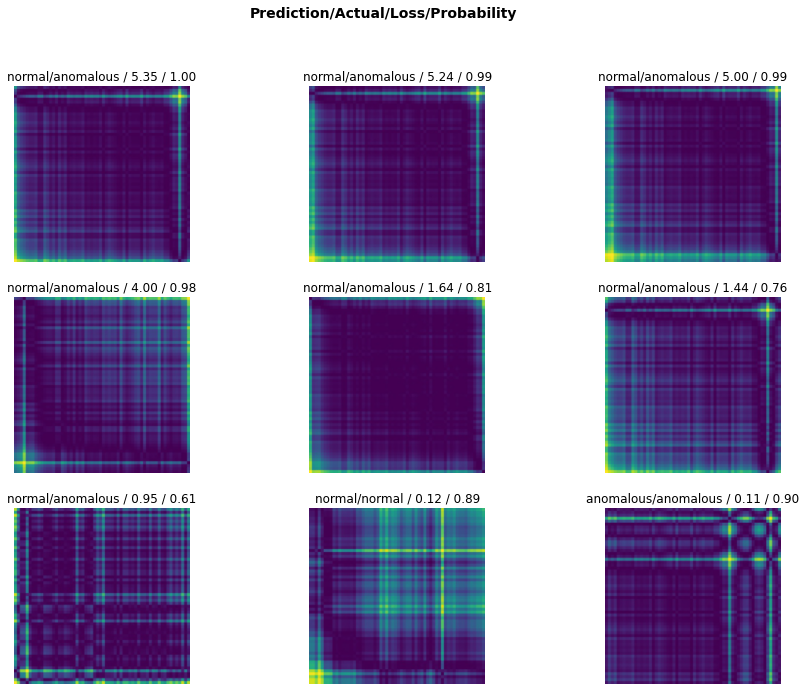

In [202]:
interp.plot_top_losses(9, figsize=(15,11))

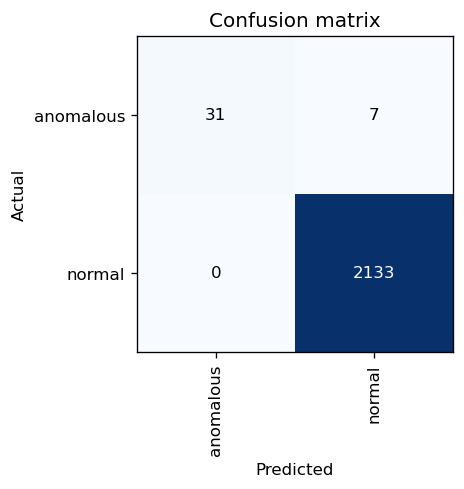

In [203]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [207]:
dls.valid_ds

(#2171) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(0)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(0)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...]

--------------------------------------


--------------------------------------


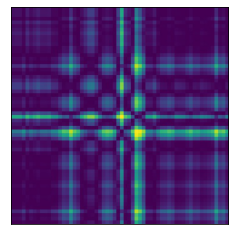

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


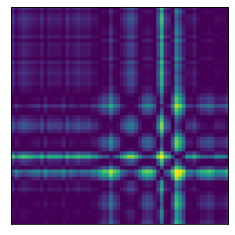

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


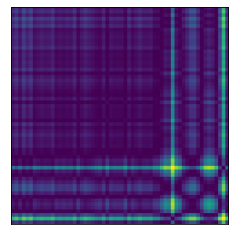

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


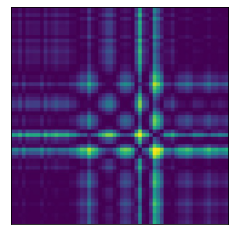

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


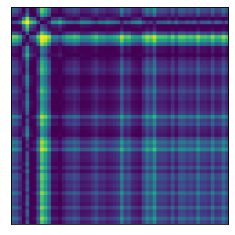

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


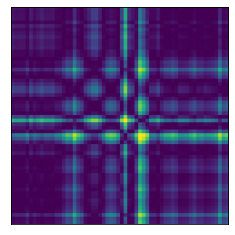

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


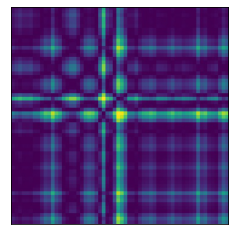

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


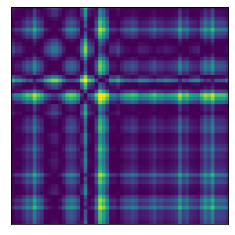

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


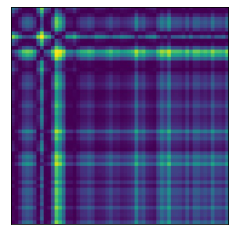

--------------------------------------


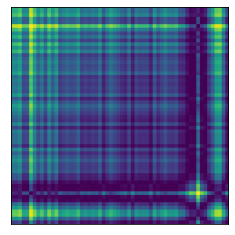

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


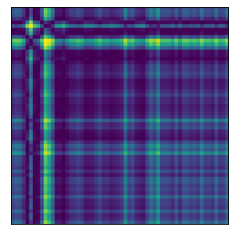

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


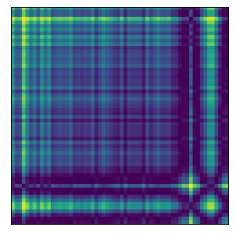

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


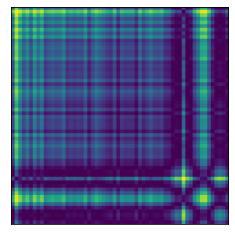

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


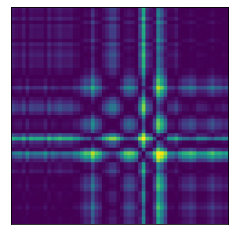

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


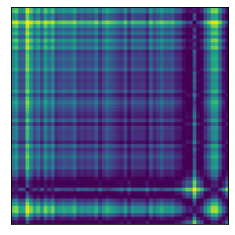

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


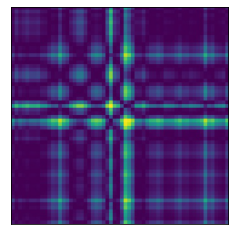

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


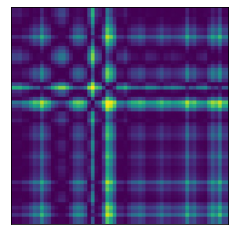

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


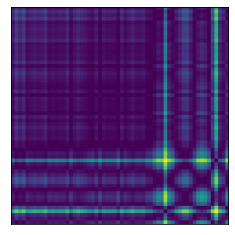

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


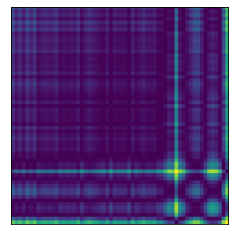

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


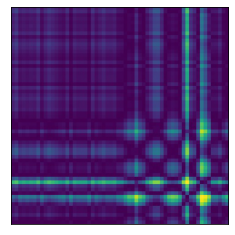

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


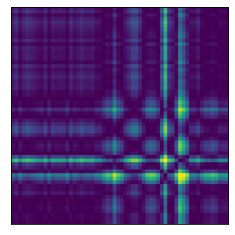

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


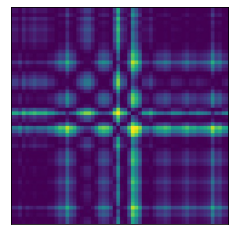

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


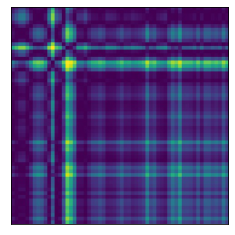

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


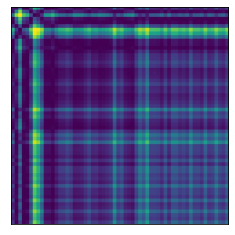

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


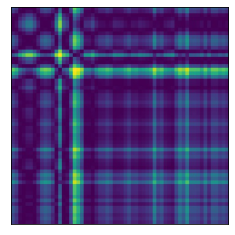

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


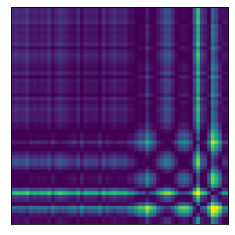

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


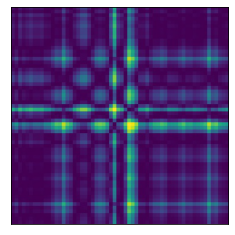

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


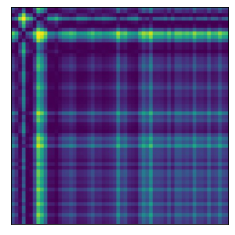

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


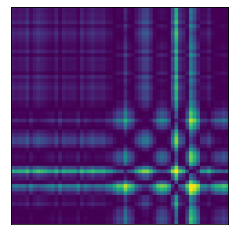

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


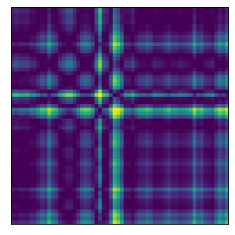

--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


--------------------------------------


KeyboardInterrupt: 

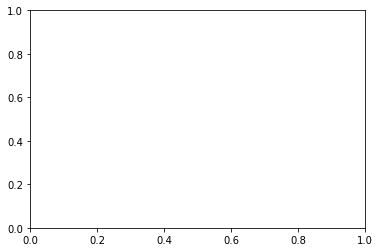

In [217]:
for i in dls.valid_ds:
    
    score = learn.predict(i[0])[0]
    
    print("--------------------------------------")
    
    if score == "anomalous":
        
#     print(i[0].show())
    
        figure = plt.imshow(i[0], cmap='viridis', origin='lower')

        x_axis = figure.axes.get_xaxis()
        x_axis.set_visible(False)

        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)

        plt.show()
        
        plt.clf()
        plt.cla()
    
    # classify 
    
    # print image and classification 
#     print(learn.predict(i[0])[0])
    
    
    

In [ ]:
# TODO: using the classifications in the validation set, can we label the time range that was deemed anomalous?

In [ ]:
# TODO: can we show an example, animation of how this model would be used in real time? 

In [ ]:
# TODO: apply to many ground station, sattelite combinations to get an overall high score 